In [1]:
from compute import Var, Par, Model, adda, addf, addsolver, geteqs, ureg, Evaluable, buildidpvars, RefNode
from compute import SOLVER, INTER, END, SolverNode
from datastructures import notation_from_tree
from notation import generate_execution, sort_scc, graphs_from_incidence, solvers_bottom_up, make_acyclic, default_sequence
from operators import standardize
from constants import ρinterp, Pinterp, Ginterp, Tinterp
from scipy import interpolate
import numpy as np
import openmdao.api as om
from representations import render_tree, digraph_repr, drawfull, tree_incidence, getpatchwindow
from anytree import Node, PreOrderIter,LevelOrderIter,RenderTree
from inputresolver import eqvars
import networkx as nx

In [2]:
from notationcompute import optsolver, solver, explicit

In [3]:
model = Model()
m = RefNode(name='/', ref=model)
rho0 = Par('\\rho_0', ρinterp(0), 'kg/m^3')
T0 = Par('T_0', Tinterp(0), 'K')
P0 = Par('P_0', Pinterp(0), 'Pa')
G0 = Par('G_0', Ginterp(0), 'm/s^2')

k = Par('k', 1.38064852e-23, 'J/K')
mm_He = Par('M_{He}', 6.64e-27, 'kg')
mm_H2 = Par('M_{H2}', 1.66e-27, 'kg')
C_D = Par('C_D', 0.47)

m_parafoil = Par('m_v', 500., 'kg')
m_vhc = Par('m_p', 4624, 'kg')
m_lg = Var('m_l', unit='kg')
m_b = Var('m_b', unit='kg')
m_t = Var('m_t', unit='kg')
adda(m, m_t, m_vhc+m_parafoil+m_lg)

alpha = Par('a', 1)
v_rise = Par('v', 6, 'm/s')
r0 = Var('r_0', unit='m')
A0 = adda(m, 'A_0', np.pi*r0**2)
V0 = adda(m, 'V_0', 4/3*np.pi*r0**3)
rho_LG0 = adda(m, '\\rho_{LG0}', P0*(alpha*mm_He+(1-alpha)*mm_H2)/(k*T0))
adda(m, m_lg, V0*rho_LG0)

L0 = adda(m, 'L_0', rho0*V0*G0)
W0 = adda(m, 'W_0', m_t*G0)
D0 = adda(m, 'D_0', 1/2*C_D*rho0*v_rise**2*A0)
R1 = addf(m, L0-D0-W0, name='R_2')
s1 = addsolver(m, geteqs(m, [A0, V0, rho_LG0, m_lg, L0, W0, D0]), [(R1, r0)], name='s1')

In [4]:
z = 30e3
rhoval = Par('\\rho_z', ρinterp(z), 'kg/m^3')
pval = Par('P_z', Pinterp(z), 'Pa')
Tval = Par('T_z', Tinterp(z), 'K')
gval = Par('G_z', Ginterp(z), 'm/s^2')
rz = Var('r_z', unit='m')
hz = adda(m, 'h_z', 2*(3/2)*rz)
Vz = adda(m, 'V_z', 4/3*np.pi*rz**3)
rho_LGz = adda(m, '\\rho_{LGz}', pval*(alpha*mm_He+(1-alpha)*mm_H2)/(k*Tval))
R2 = addf(m, m_lg-Vz*rho_LGz, name='R_2') #needs to have same mass as balloon at STP
s2 = addsolver(m, geteqs(m, [rz, hz, Vz, rho_LGz]), [(R2, rz)], name='s2')

In [5]:
G, graphs = graphs_from_incidence(m, from_root=True)

In [6]:
m2 = make_acyclic(m, graphs)

In [7]:
render_tree(m2, display_type=True)

/               
├── ., SOLVER   
│   ├── f_{1}, END
│   ├── f_{2}, END
│   ├── f_{3}, END
│   ├── f_{6}, END
│   ├── f_{7}, END
│   ├── f_{5}, END
│   ├── f_{4}, END
│   ├── R_2, END
│   └── f_{0}, END
└── s2, SOLVER  
    ├── f_{9}, INTER
    ├── f_{10}, INTER
    ├── f_{11}, INTER
    └── R_2, END


In [10]:
sequence_m2 = default_sequence(m2)
sequence_m = default_sequence(m)

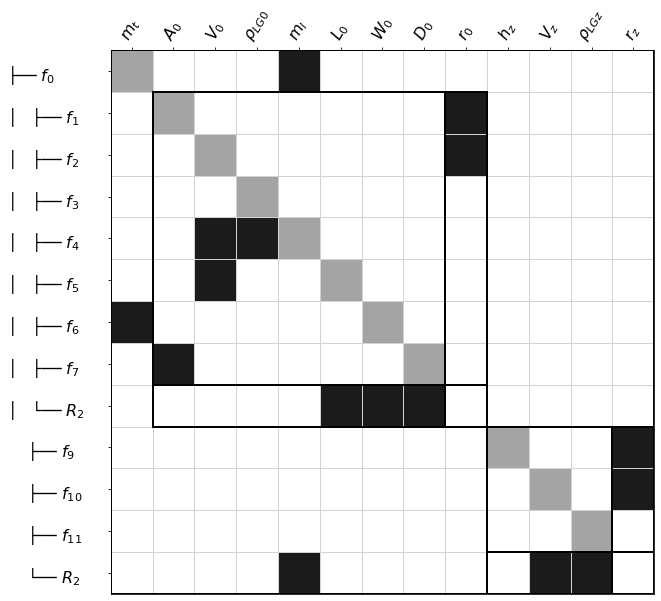

In [11]:
tree_incidence(m, eqvars(model.eqs), model.outset, sequence_m, figsize=(10,10));

In [11]:
render_tree(m2, display_type=True)

/               
├── ., SOLVER   
│   ├── f_{1}, END
│   ├── f_{2}, END
│   ├── f_{3}, END
│   ├── f_{6}, END
│   ├── f_{7}, END
│   ├── f_{5}, END
│   ├── f_{4}, END
│   └── f_{0}, END
└── s2, SOLVER  
    ├── f_{9}, INTER
    ├── f_{10}, INTER
    ├── f_{11}, INTER
    └── R_2, END


In [20]:
G, graphs = graphs_from_incidence(m2, from_root=True)

In [23]:
newsolver = list(graphs.keys())[0]

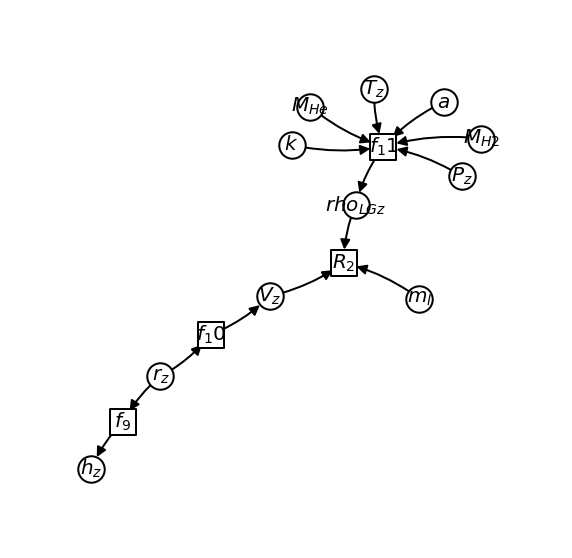

In [24]:
drawfull(graphs[newsolver], m2.ref.eqs, figsize=(10,10))

In [16]:
branch_node = m

In [17]:
#first copy all the leaves (from the m.tree)
model = branch_node.ref
m_new = RefNode(name='/', ref=model)

In [18]:
new_nodes = {elt: RefNode(elt.name, ref=elt.ref, node_type=elt.node_type) if elt.node_type !=SOLVER else SolverNode(elt.name, m_new, refonly=True) for elt in PreOrderIter(branch_node) if elt != branch_node}
new_nodes[branch_node] = m_new

In [19]:
from_root = True
merge_order = solvers_bottom_up(branch_node, from_root)

In [28]:
solver_branch = merge_order[2]

In [29]:
mdf = True
scc = sort_scc(graphs[solver_branch], [elt for elt in solver_branch.children])

In [30]:
order = []
for cc in scc:
    if len(cc) == 1:
        node = next(iter(cc))
        new_nodes[node].parent = new_nodes[solver_branch]
    else:
        stcc = []
        for node in cc:
            stcc += standardize(new_nodes[node])
            if node.node_type==SOLVER: #we "delete' the solver node
                new_nodes[node].parent = None
        if mdf:
            order += [addsolver(new_nodes[solver_branch], stcc)]
        else:
            order += stcc

In [31]:
render_tree(m_new)

/               
├── .           
│   ├── f_0     
│   ├── f_1     
│   ├── f_2     
│   ├── f_3     
│   ├── f_6     
│   ├── f_7     
│   ├── f_5     
│   └── f_4     
└── s2          
    ├── f_9     
    ├── f_10    
    ├── f_11    
    └── r_12    


In [69]:
for pre, _, node in RenderTree(m2):
        treestr = u"{}{}{}".format(pre, node.name, node.node_type)
        print(treestr.ljust(16))

/None           
└── s1NodeTypes.SOLVER
    ├── f_1NodeTypes.INTER
    ├── f_2NodeTypes.INTER
    ├── f_3NodeTypes.INTER
    ├── f_7NodeTypes.INTER
    ├── f_5NodeTypes.INTER
    ├── f_4NodeTypes.INTER
    ├── f_0NodeTypes.INTER
    ├── f_6NodeTypes.INTER
    └── r_8NodeTypes.END


In [23]:
scc = sort_scc(graphs[solver], eqs)

In [24]:
scc

[{f_1}, {f_2}, {f_6}, {f_7}, {f_4}, {f_5}, {r_8}]

In [ ]:
for solver in merge_order:
    scc = sort_scc(graphs[solver], eqs)
    order = []
    for cc in scc:
        if len(cc) == 1:
            order += [next(iter(cc))]
        else:
            stcc = [elt for node in cc for elt in standardize(cc)]
            if mdf:
                order += [addsolver(solver, stcc)]
            else:
                order += stcc
    for node in order: # to order things correctly
        node.parent = solver

In [4]:
eqs, eqv, dout, _ = m.data_structures()

In [5]:
G, _ = digraph_repr(eqv, dout, intermediary=True)

In [6]:
seq = [n for elt in sort_mdf(G, eqs) for n in elt]

In [7]:
s = addsolver(m, seq, [('r_8', r0)]) #states that everything else will be considered an input
addsolver(s, otherseq) #<- otherseq could either be within seq or not
# there should also be an option to declare which variables should be inputs

In [8]:
_,_,_,dins = m.data_structures() #dins update because we added r0 to the outputset

In [11]:
# add all to a solver (which is technically a feasability solver, aka isoperf that we don't have)
# which we further specialize into a projected feasability solver

In [9]:
notation = notation_from_tree(s, m.outset)

In [10]:
notation

([r0],
 [(A0, 'f_1'),
  (V0, 'f_2'),
  (rho_LG0, 'f_3'),
  (D0, 'f_7'),
  (L0, 'f_5'),
  (m_l, 'f_4'),
  (m_t, 'f_0'),
  (W0, 'f_6'),
  'r_8'])

# Execution

In [11]:
prob = om.Problem()
model = prob.model
groups = {0:model}

In [12]:
{elt for elt in dins if not elt.always_input}

set()

In [13]:
dins

[C_D, a, v, T0, G0, mp, k, mm_H2, P0, mm_He, rho0, mv]

In [14]:
buildidpvars(dins, model)

In [ ]:
[([r], [(A0, 1), (V0, 2), (rho_LG0, 3), (m_lg, 4), (m_t, 0), (L0, 0), (W0, 0), (D0, 0)])]

In [17]:
execorder = generate_execution([notation])
execorder

[('solver', 0, 1, [r0], ['r_8']),
 ('exp', 1, A0, 'f_1'),
 ('exp', 1, V0, 'f_2'),
 ('exp', 1, rho_LG0, 'f_3'),
 ('exp', 1, D0, 'f_7'),
 ('exp', 1, L0, 'f_5'),
 ('exp', 1, m_l, 'f_4'),
 ('exp', 1, m_t, 'f_0'),
 ('exp', 1, W0, 'f_6')]

In [18]:
mapping = {'solver': solver, 'exp':explicit}

In [20]:
for fxname, *args in execorder:
    mapping[fxname](groups, eqs, *args)

In [11]:
solver(groups, eqs, 0, 1, [r0], [8])
explicit(groups, eqs, 1, A0, 1)
explicit(groups, eqs, 1, V0, 2)
explicit(groups, eqs, 1, rho_LG0, 3)
explicit(groups, eqs, 1, m_lg, 4)
explicit(groups, eqs, 1, m_t, 0)
explicit(groups, eqs, 1, L0, 5)
explicit(groups, eqs, 1, W0, 6)
explicit(groups, eqs, 1, D0, 7)

In [21]:
prob.setup();

In [22]:
prob.get_val('r0')

array([1.])

In [23]:
#prob.set_val('r0', 12)
prob.run_model()


group1
NL: Newton Converged in 16 iterations


In [24]:
model.list_outputs();

20 Explicit Output(s) in 'model'

varname      val             
-----------  ----------------
inp
  C_D        [0.47]          
  a          [1.]            
  v          [6.]            
  T0         [288.15]        
  G0         [9.807]         
  mp         [4624.]         
  k          [1.38064852e-23]
  mm_H2      [1.66e-27]      
  P0         [101300.]       
  mm_He      [6.64e-27]      
  rho0       [1.225]         
  mv         [500.]          
group1
  eqf_1
    A0       [363.64624836]  
  eqf_2
    V0       [5216.53910562] 
  eqf_3
    rho_LG0  [0.16907359]    
  eqf_7
    D0       [3768.64789486] 
  eqf_5
    L0       [62669.28378577]
  eqf_4
    m_l      [881.97898347]  
  eqf_0
    m_t      [6005.97898347] 
  eqf_6
    W0       [58900.63589091]


1 Implicit Output(s) in 'model'

varname   val          
--------  -------------
group1
  resr_8
    r0    [10.75881945]


